# Modelo SEIRD para ciudades y departamentos en Colombia

powered by @El_Dryosa juvenal.yosa@unisimonbolivar.edu.co

No soy epidemiólogo, ni tengo experiencia en este tipo de análisis, pero he estado trabajando durante estos meses tratando de generar un modelo que se ajuste a los datos oficiales, especialmente al número de fallecidos, ya que son los datos más confiables al número de contagiados, aunque eso no quiere decir que también se puedan encontrar errores, subregistros etc. A continuación vamos a realizar un modelo SEIRD (Suceptibles-Expuestos-Infectados-Reucperados-Muertos), que puede aplicarlos y ajustar los parámetros dependiendo el número de muertos y datos reales por el Instituto Nacional de salud. Vamos a realizar un ejemplo con la ciudad de Bogotá.

In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.integrate import odeint
import lmfit
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import os
import datetime as dt  
from scipy.optimize import minimize
from numpy import log
import math
from datetime import datetime
from datetime import timedelta, date

### Programando las ecuaciones diferenciales

Lo único diferente que vamos a realizar es  $R_0$ que utilizaremos una función logística de la siguiente forma:

$$R_0(t) = \frac {R_{0start} - R_{0end}}{1 + e^{-k(-x+x_0)}} + R_{0end}$$

El resto de información lo puede consegir en https://github.com/jyosa/covid-19_colombia/blob/master/covid_lat.ipynb

In [2]:
def deriv(y, t, N, beta, gamma, delta, alpha, rho):
    S, E, I, R, D = y

    dSdt = -beta(t) * S * I / N 
    dEdt = beta(t) * S * I / N - delta * E
    dIdt = delta * E - (1 - alpha) * gamma * I - alpha * rho * I
    dRdt = (1 - alpha) * gamma * I
    dDdt = alpha * rho * I
    return dSdt, dEdt, dIdt, dRdt, dDdt

# Fit least square

gamma = 1.0/4.0

def logistic_R_0(t, R_0_start, k, x0, R_0_end):
    return (R_0_start-R_0_end) / (1 + np.exp(-k*(-t+x0))) + R_0_end

def Model(days, N, R_0_start, k, x0, R_0_end, delta, alpha, rho):

    def beta(t):
        return logistic_R_0(t, R_0_start, k, x0, R_0_end) * gamma
    # beta = R_0 * gamma
    
    #Sum all groups per ages (check statistics per region)
    
    # def Beds(t):
    #     beds_0 = beds_per_100k / 100_000 * N
    #     return beds_0 + s*beds_0*t  # 0.003
    y0 = N-1, 1.0, 0.0, 0.0, 0.0
    t = np.linspace(0, days-1, days)
    ret = odeint(deriv, y0, t, args=(N, beta, gamma, delta, alpha, rho))
    S, E, I, R, D = ret.T
    R_0_over_time = [beta(i)/gamma for i in range(len(t))]
    return t, S, E, I, R, D, R_0_over_time
# fit function
def fitter(x, R_0_start, k, x0, R_0_end, delta, alpha, rho):
    ret = Model(days, N, R_0_start, k, x0, R_0_end, delta, alpha, rho)
    return ret[5][x]

#### Bajando y formateando datos del Instituto Nacional de Salud INS

In [3]:
url_data='https://www.datos.gov.co/api/views/gt2j-8ykr/rows.csv?accessType=DOWNLOAD'
df_dat = pd.read_csv(url_data, sep = ",")

##### Aquí necesita colocar los datos de su ciudad o departamento, cambiando las variable depcity y nombre, dependiendo el caso que quiera simular y el total de la población de su ciudad o departamento

In [4]:
#Tomar datos ciudad o departamento
#Parametros a cambiar
depcity='Departamento'
nombre='Bogotá D.C.'
N=7413000
#########################################


if depcity == 'Departamento':
    mun_all=[nombre]
    df_baq = df_dat.loc[df_dat['Departamento o Distrito '].isin(mun_all)]
elif depcity == 'Ciudad':
    mun_all=[nombre]
    df_baq = df_dat.loc[df_dat['Ciudad de ubicación'].isin(mun_all)]
    print(df_baq)
else:
    print('Ingrese Ciudad o Departamento')
    exit()

##### Algunas estadísticas

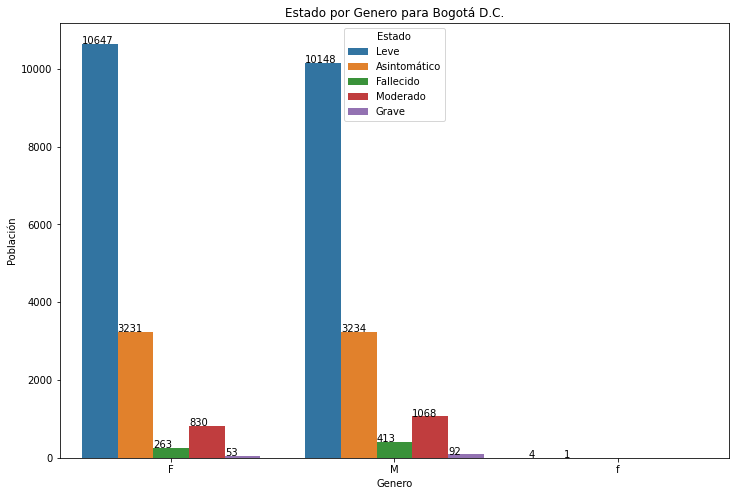

Estado
Asintomático     6466
Fallecido         676
Grave             145
Leve            20799
Moderado         1898
Name: Estado, dtype: int64


In [6]:
plt.figure(figsize=(12,8))
title_plot = 'Estado por Genero para ' + nombre
ax = sns.countplot(x = 'Sexo', hue = 'Estado', data = df_baq)
plt.title(title_plot)
plt.xlabel('Genero')
plt.ylabel('Población')
for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x(), p.get_height()))
plt.show()

print(df_baq.groupby('Estado').Estado.count())


In [9]:
df_baq['FIS']= pd.to_datetime(df_baq['FIS'], errors='coerce') 
df_baq['Fecha diagnostico']= pd.to_datetime(df_baq['Fecha diagnostico'], errors='coerce') 
df_baq['Fecha recuperado']= pd.to_datetime(df_baq['Fecha recuperado'], errors='coerce')
df_baq['Fecha de muerte']= pd.to_datetime(df_baq['Fecha de muerte'], errors='coerce')

#Hacer conteo por día para los infectados, muertos y recuperados
df_baq['count_inf'] = df_baq.groupby('Fecha diagnostico')['Fecha diagnostico'].transform('count')

check_muertos = df_baq['Fecha de muerte'].isnull().sum()
check_rows = df_baq.shape[0]


if check_muertos == check_rows:
    print('')
    print('==========================================================================================')
    print('No se han reportado muertos en {} por lo que no es posible ajustar a un modelo SIR'.format(nombre))
    print('==========================================================================================')
    print('')

    exit()

df_baq['count_muer'] = df_baq.groupby('Fecha de muerte')['Fecha de muerte'].transform('count')
df_baq['count_rec'] = df_baq.groupby('Fecha recuperado')['Fecha recuperado'].transform('count')


#diferencia Fecha inicio de sintomas y fecha recuperadps
df_baq['diff_days'] = df_baq['Fecha recuperado'] - df_baq['FIS']
df_baq['diff_days']=df_baq['diff_days']/np.timedelta64(1,'D')
prom_diff_dias = df_baq["diff_days"].mean()
print('Promedio desde inicio de síntomas hasta la recuperación = {} días'.format(prom_diff_dias))
var1=['Fecha diagnostico','count_inf']
var2=['Fecha de muerte','count_muer']
var3=['Fecha recuperado','count_rec']
#rango de fechas
today = dt.datetime.today().strftime("%Y-%m-%d")
inicio = df_baq['Fecha diagnostico'].iloc[0]


idx = pd.date_range(inicio, today)
#Infectados serie de tiempo
infectados = df_baq[var1]
infectados = infectados.sort_values(by=['Fecha diagnostico'])
infectados = infectados.drop_duplicates(subset='Fecha diagnostico', keep='last')
infectados.set_index('Fecha diagnostico', inplace=True)
infectados = infectados.reindex(idx,  fill_value=0)
infectados['cum_sum'] = infectados['count_inf'].cumsum()
#Muertos serie de tiempo
muertos = df_baq[var2]
muertos = muertos.sort_values(by=['Fecha de muerte'])
muertos = muertos.drop_duplicates(subset='Fecha de muerte', keep='last')
muertos.set_index('Fecha de muerte', inplace=True)
muertos = muertos.reindex(idx,  fill_value=0)
muertos['cum_sum'] = muertos['count_muer'].cumsum()
#Recuperados serie de tiempo
recuperados = df_baq[var3]
recuperados = recuperados.sort_values(by=['Fecha recuperado'])
recuperados = recuperados.drop_duplicates(subset='Fecha recuperado', keep='last')
recuperados.set_index('Fecha recuperado', inplace=True)
recuperados = recuperados.reindex(idx,  fill_value=0)
recuperados['cum_sum'] = recuperados['count_rec'].cumsum()

Promedio desde inicio de síntomas hasta la recuperación = 29.99181446111869 días


##### Con los datos obtenidos del INS ahora vamos a ajustar el número de muertos acumulados para un modelo SEIRD. El parámetro outbreak_shift se define como el día en que el paciente 0 ingresa a la ciudad o el departamento, asumimos que ha sido 30 días antes para el caso de Bogotá. Usted  puede cambiar los parámetros a continuación para que se ajuste mejor, recuerde que los valores iniciales para ajustar a un modelo no lineal es muy importante.

params_init_min_max = {"R_0_start": (4.5, 1.0, 5.0), "k": (1.0, 0.99, 1.001), "x0": (90, 20, 120), "R_0_end": (1.7, 0.8, 3.5),
                         "delta": (0.2, 0.07, 0.2), "alpha": (0.001, 0.0005, 0.002), "rho": (0.09, 0.04, 0.07)}

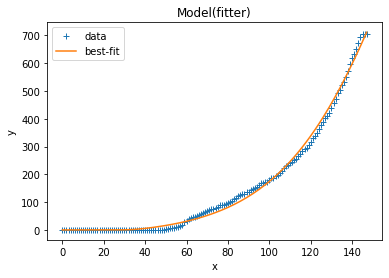

In [11]:
data = muertos['cum_sum'].to_numpy()
outbreak_shift = 30
params_init_min_max = {"R_0_start": (4.5, 1.0, 9.0), "k": (1.0, 0.1, 1.001), "x0": (90, 20, 120), "R_0_end": (1.7, 0.8, 3.5),
                         "delta": (0.2, 0.07, 0.2), "alpha": (0.001, 0.0005, 0.002), "rho": (0.05, 0.02, 0.065)}  # form: {parameter: (initial guess, minimum value, max value)}
                       
                       # delta incubation period
                       # alpha death rate    
                       # rho inverse days of infection until death
                       # rho inverse days of infection until death
# Defining num of days 
days = outbreak_shift + len(data)

# This is the whole simulation time for extended SIR
full_days = 400

if outbreak_shift >= 0:   
    y_data = np.concatenate((np.zeros(outbreak_shift), data))
    real_time = inicio - timedelta(days=outbreak_shift)
else:
    y_data = data[-outbreak_shift:]
    real_time = inicio + timedelta(days=outbreak_shift)

x_data = np.linspace(0, days - 1, days, dtype=int)  
x_tiempo = pd.date_range(real_time, periods=days).tolist()

tiempo = pd.date_range(real_time, periods=full_days).tolist()


#############################################################################

mod = lmfit.Model(fitter)

for kwarg, (init, mini, maxi) in params_init_min_max.items():
    mod.set_param_hint(str(kwarg), value=init, min=mini, max=maxi, vary=True)

params = mod.make_params()
fit_method = "leastsq"


##############################################################################


result = mod.fit(y_data, params, method="least_squares", x=x_data)

##############################################################################


result.plot_fit(datafmt="+")

##### El modelo ajusta muy bien!!!! Ahora usamos los parámetros optimizados para realizar el modelo SEIRD

Prediction for Bogotá D.C.
{'R_0_start': 8.999999999420044, 'k': 1.0009999999959134, 'x0': 33.64062473984944, 'R_0_end': 1.5256706596618612, 'delta': 0.10083943510298082, 'alpha': 0.0019999999999999996, 'rho': 0.06499999999999999}


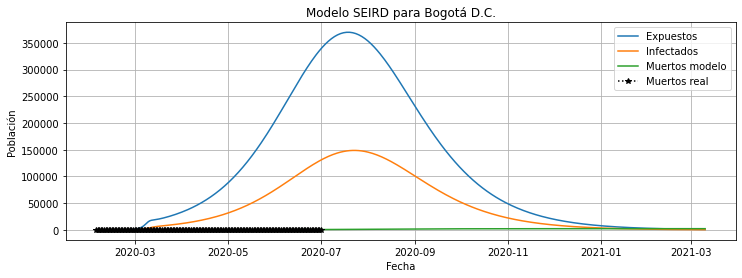

In [12]:
first_date = np.datetime64(infectados.index.min()) - np.timedelta64(outbreak_shift,'D')
x_ticks = pd.date_range(start=first_date, periods=full_days, freq="D")
print("Prediction for {}".format(nombre))

final_model = Model(full_days, N, **result.best_values)
print(result.best_values)




fig = plt.figure(figsize=(12,4))
#plt.plot(tiempo,final_model[1])
plt.plot(tiempo,final_model[2])
plt.plot(tiempo,final_model[3])
#plt.plot(tiempo,final_model[4])
plt.plot(tiempo,final_model[5])
# #plt.plot(tiempo,final_model[6])
plt.plot(x_tiempo,y_data,"k*:")
plt.grid("True")
plt.xlabel("Fecha")
plt.ylabel("Población")
plt.legend(["Expuestos", "Infectados", 'Muertos modelo', 'Muertos real'])
title = 'Modelo SEIRD para ' + nombre
plt.title(title)
#plt.legend(["Exposed","Infected","Critical",'Dead','Real Dead'])
plt.show()


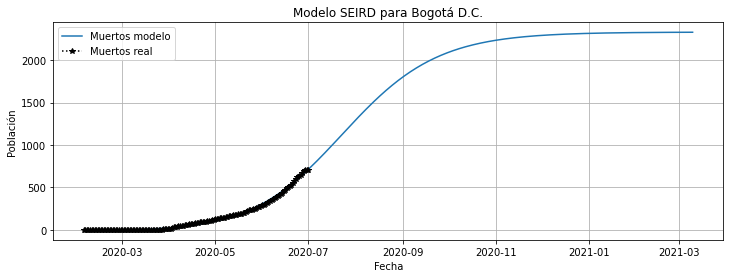

In [13]:
fig = plt.figure(figsize=(12,4))
plt.plot(tiempo,final_model[5])
plt.plot(x_tiempo,y_data,"k*:")
plt.grid("True")
plt.xlabel("Fecha")
plt.ylabel("Población")
plt.legend(['Muertos modelo', 'Muertos real'])
plt.title(title)
plt.show()

In [21]:
print('Fallecidos proyectados a la fecha modelo: {}'.format(int(final_model[5][days-1])))
print('Fallecidos reportados a la fecha: {}'.format(data.max()))
print('infectados modelo: {}'.format(int(final_model[3][days-1])))
inf_hoy = np.amax(infectados[["cum_sum"]].to_numpy())
print('infectados evaluados = {}'.format(inf_hoy))
print('Proporción aproximada de infectados evaluados = {}%'.format((inf_hoy*100)/int(final_model[3][days-1])))
print('factor de escalamiento = {}'.format(int(final_model[3][days-1])/inf_hoy))
print('Parámetros usados :')
print('R_0 = {}'.format(result.best_values['R_0_end']))
print('Periodo de incubación = {} días'.format(1/result.best_values['delta']))
print('Tasa de mortalidad = {} %'.format(result.best_values['alpha']*100))
print('Días desde la infección hasta la muerte = {} días'.format(1/result.best_values['rho']))
print('Fecha probable del máximo número de infectados = {}'.format(tiempo[np.argmax(final_model[3], axis=0)]))



Fallecidos proyectados a la fecha modelo: 711
Fallecidos reportados a la fecha: 705.0
infectados modelo: 130497
infectados evaluados = 30000.0
Proporción aproximada de infectados evaluados = 22.98903423067197%
factor de escalamiento = 4.3499
Parámetros usados :
R_0 = 1.5256706596618612
Periodo de incubación = 9.916755275143741 días
Tasa de mortalidad = 0.19999999999999996 %
Días desde la infección hasta la muerte = 15.384615384615387 días
Fecha probable del máximo número de infectados = 2020-07-23 00:00:00


#### Los parámetros obtenidos en el ajuste reflejan bastante bien la realidad! 